In [1]:
# Import all neccesary python libraries for analysis.
import pymc as pm
import pandas as pd
import pyreadr
import nutpie
import arviz as az

# Overview

The following analysis is a Bayesian hierchial model generated using the PyMC PPL framework and the associated Rust based nutpie Hamiltonian monte Carlo sampler. The basis for this analysis is from Harrer et al. (2021) whom used R and the brms package.

In [2]:
# Import rda file into OrderedDict.
keys = pyreadr.read_r("data/ThirdWave.rda")

# Extract from OrderedDict the pandas dataframe.
df = keys["ThirdWave"]

# Extract the data for analysi
seTE = df["seTE"]
# Convert to integer to make the model code work below.


df['Author'] = pd.Categorical(df['Author'])
author_id = df['Author'].cat.codes
TE = df["TE"]

# The Bayesian Hierachial model

\begin{align*}  

\ \hat\theta_k &\sim Normal(\theta_k, \sigma_k)
\\ \theta_k &\sim Normal(\mu, \tau) 
\\ \mu &\sim Normal(0, 1) 
\\ \tau &\sim HalfCauchy(0, .5) 


\end{align*}


In [9]:
# Generate pymc Bayesian Hierachial model
with pm.Model() as model:
    
    intercept = pm.Normal("intercept", mu = 0, sigma = 1)
    sigma_a = pm.HalfCauchy("sigma_a", beta=.5)
    # Random intercepts
    alpha = pm.Normal('alpha', mu=0, sigma = sigma_a, shape=len(df["Author"].unique()))
    y = pm.Normal("y", mu = intercept + alpha[author_id], sigma = seTE, observed=TE)
   

In [14]:
# Compile nutpie pymc model.
compiled_model = nutpie.compile_pymc_model(model)
trace = nutpie.sample(compiled_model)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.56,7
,1300,0,0.63,7
,1300,0,0.55,7
,1300,0,0.59,7
,1300,0,0.59,7
,1300,0,0.59,7


In [24]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y]


/home/harrison/anaconda3/envs/pymc_env/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [15]:
# Get the results of the model MCMC samples.
az.summary(trace, var_names=["sigma_a", "intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.294,0.100,0.114,0.488,0.003,0.002,878.0,516.0,1.0
intercept,0.569,0.092,0.404,0.755,0.002,0.002,1709.0,2408.0,1.0


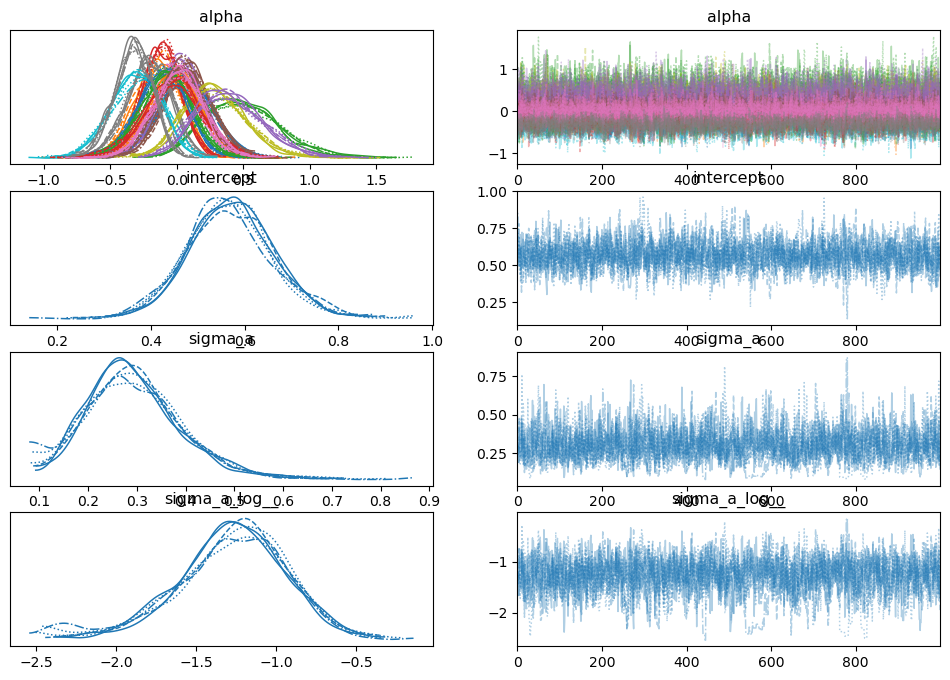

In [22]:
az.plot_trace(trace);

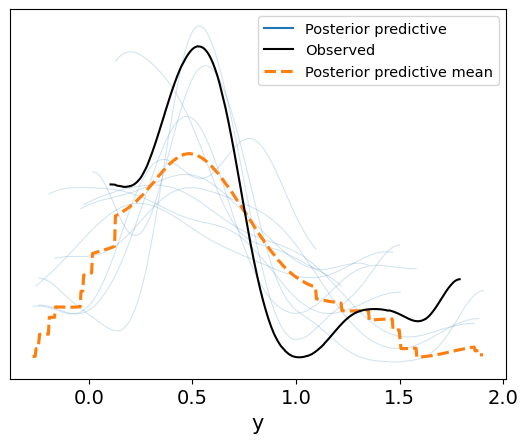

In [30]:
az.plot_ppc(trace, num_pp_samples=10);

# References
Harrer, M., Cuijpers, P., Furukawa, T.A., & Ebert, D.D. (2021). Doing Meta-Analysis with R: A Hands-On Guide. Boca Raton, FL and London: Chapmann & Hall/CRC Press. ISBN 978-0-367-61007-4.

Röver, Christian. 2017. “Bayesian Random-Effects Meta-Analysis Using the ‘Bayesmeta‘ r Package.” ArXiv Preprint 1711.08683.